In [ ]:
# Setup venv and install jupyter kernel
import sys
!{sys.executable} -m venv cebra
!cebra/bin/python -m pip install --upgrade pip
!cebra/bin/python -m pip install jupyter ipykernel
!cebra/bin/python -m ipykernel install --user --name=cebra --display-name "Python (CEBRA)"

In [2]:
# Check venv has been registered as juptyer kernel
!jupyter kernelspec list

Available kernels:
  cebra      /home/jake/.local/share/jupyter/kernels/cebra
  python3    /home/jake/.local/share/jupyter/kernels/python3


In [3]:
# Restart kernel and switch to Python (CEBRA)

In [4]:
import sys
sys.executable # check that we're using the correct kernel `.../cebra/bin/python`

'/home/jake/cebra/bin/python'

In [ ]:
# !{sys.executable} -m pip install --pre 'cebra[datasets,demos]'
# !{sys.executable} -m pip install --upgrade git+https://github.com/AdaptiveMotorControlLab/cebra.git


In [ ]:
import torch
print(torch.version.cuda)
# 12.4

In [ ]:
# torch>=2.6 breaks loading cebra models, so downgrade to 2.5.0
# !{sys.executable} -m pip uninstall -y torch torchvision torchaudio
# !{sys.executable} -m pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import cebra.datasets
from cebra import CEBRA

In [2]:
import random
import copy
import torch
import numpy as np
# !mkdir data

# Set seeds for reproducibility
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

hippocampus_pos = {}
hippocampus_pos["achilles"] = cebra.datasets.init('rat-hippocampus-single-achilles')
hippocampus_pos["buddy"] = cebra.datasets.init('rat-hippocampus-single-buddy')
hippocampus_pos["cicero"] = cebra.datasets.init('rat-hippocampus-single-cicero')
hippocampus_pos["gatsby"] = cebra.datasets.init('rat-hippocampus-single-gatsby')

def shuffle_time_independently(array):
    # Assuming array shape is (time, neurons)
    # Create an empty tensor of the same shape
    shuffled = torch.empty_like(array)
    for neuron in range(array.shape[1]):
        # Generate a random permutation for each neuron's time series
        perm = torch.randperm(array.shape[0])
        shuffled[:, neuron] = array[perm, neuron]
    return shuffled

# Create shuffled datasets with a new key, replacing the neural attribute.
for key in list(hippocampus_pos.keys()):
    shuffled_dataset = copy.deepcopy(hippocampus_pos[key])
    shuffled_dataset.neural = shuffle_time_independently(shuffled_dataset.neural)
    hippocampus_pos[f"{key}_shuffled"] = shuffled_dataset

# Apply log1p and per-neuron standardization to neural data,
# and standardize continuous_index.
for key in hippocampus_pos.keys():
    data = hippocampus_pos[key]
    
    # Take log1p of neural data
    neural_log = torch.log1p(data.neural)
    
    # Compute mean and std for each neuron (across the time dimension)
    neuron_mean = neural_log.mean(dim=0, keepdim=True)
    neuron_std = neural_log.std(dim=0, keepdim=True)
    
    # Identify neurons with little or no variance.
    valid_mask = neuron_std > 1e-6
    if valid_mask.sum() < neuron_std.shape[1]:
        num_removed = neuron_std.shape[1] - valid_mask.sum().item()
        print(f"{num_removed} neuron(s) removed from {key} due to near-zero variance.")
    
    # Filter out neurons with near-zero variance.
    neural_log = neural_log[:, valid_mask.squeeze()]
    neuron_mean = neuron_mean[:, valid_mask.squeeze()]
    neuron_std = neuron_std[:, valid_mask.squeeze()]
    
    # Standardize each neuron individually.
    data.neural_standardized = (neural_log - neuron_mean) / neuron_std

    # Standardize continuous_index across the feature dimension.
    ci_mean = data.continuous_index.mean(dim=0, keepdim=True)
    ci_std = data.continuous_index.std(dim=0, keepdim=True)
    data.continuous_index_standardized = (data.continuous_index - ci_mean) / ci_std

    hippocampus_pos[key] = data

print(hippocampus_pos.keys())


1 neuron(s) removed from achilles due to near-zero variance.
3 neuron(s) removed from buddy due to near-zero variance.
1 neuron(s) removed from gatsby due to near-zero variance.
1 neuron(s) removed from achilles_shuffled due to near-zero variance.
3 neuron(s) removed from buddy_shuffled due to near-zero variance.
1 neuron(s) removed from gatsby_shuffled due to near-zero variance.
dict_keys(['achilles', 'buddy', 'cicero', 'gatsby', 'achilles_shuffled', 'buddy_shuffled', 'cicero_shuffled', 'gatsby_shuffled'])


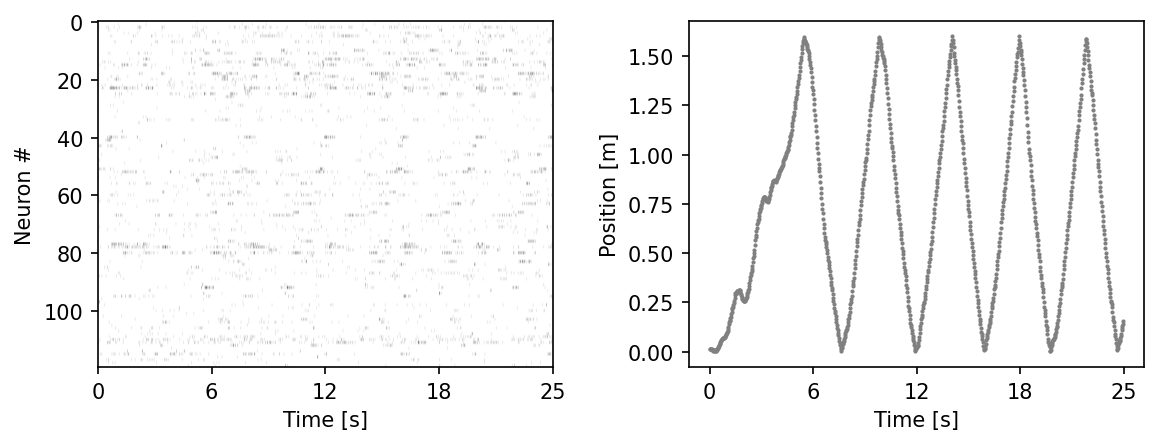

In [3]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos["achilles"].neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos["achilles"].continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.savefig("./cebra_figures/original_unshuffled_data.png", bbox_inches="tight")
plt.show()

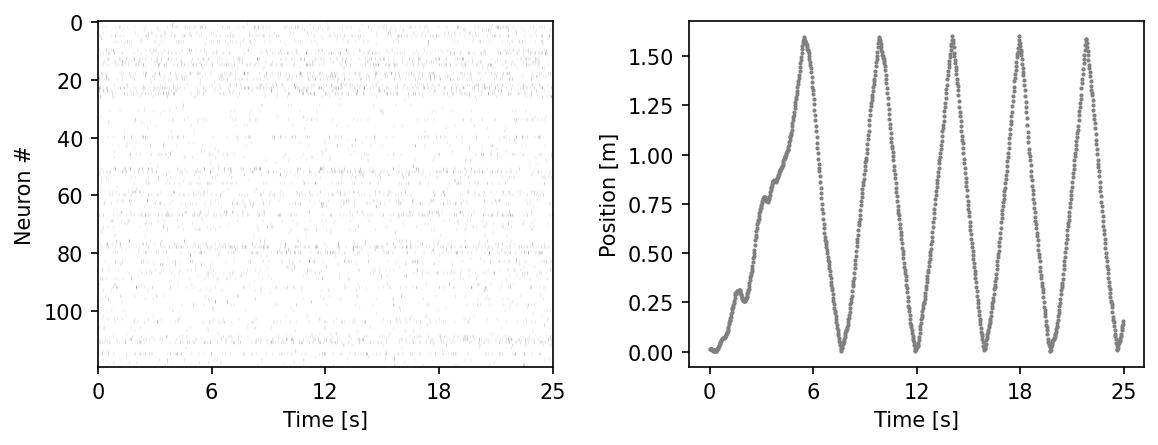

In [4]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos["achilles_shuffled"].neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos["achilles_shuffled"].continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.savefig("./cebra_figures/shuffled_data.png", bbox_inches="tight")
plt.show()

According to the docs we can increase the model size ad libitum for "better embeddings", no mention of overfitting. https://cebra.ai/docs/api/sklearn/cebra.html#cebra.CEBRA.num_hidden_units

```
num_hidden_units (int):
    The number of dimensions to use within the neural network model. Higher numbers slow down training,
    but make the model more expressive and can result in a better embedding. Especially if you find
    that the embeddings are not consistent across runs, increase :py:attr:`~.num_hidden_units` and
    :py:attr:`~.output_dimension` to increase the model size and output dimensionality.
    |Default:| ``32``.
```



In [5]:
# for mouse in list(hippocampus_pos.keys()):
#     seed_everything(42)
#     cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
#                             batch_size=1024,
#                             learning_rate=3e-4,
#                             temperature=1,
#                             output_dimension=3,
#                             max_iterations=20000,
#                             distance='cosine',
#                             conditional='time_delta',
#                             device='cuda_if_available',
#                             verbose=True,
#                             num_hidden_units=256, 
#                             time_offsets=10,
#                             optimizer_kwargs={"betas": (0.9, 0.95)} # Betas from arXiv: https://arxiv.org/abs/2303.15343
#                                )
#     # Use standardized data so we don't spend thousands of training steps learning the data scale
#     cebra_posdir3_model.fit(hippocampus_pos[mouse].neural_standardized, hippocampus_pos[mouse].continuous_index_standardized.numpy())
#     cebra_posdir3_model.save(f"./cebra_models/cebra_posdir3_model_{mouse}.pt")

In [6]:
# dimensionalities = [8, 16, 32, 64, 128, 256]
# keys_to_use = ["achilles", "achilles_shuffled"]

# for mouse in keys_to_use:
#     for dim in dimensionalities:
#         seed_everything(42)
#         cebra_model = CEBRA(
#             model_architecture='offset10-model',
#             batch_size=1024,
#             learning_rate=3e-4,
#             temperature=1,
#             output_dimension=3,
#             max_iterations=20000,
#             distance='cosine',
#             conditional='time_delta',
#             device='cuda_if_available',
#             verbose=True,
#             num_hidden_units=dim,
#             time_offsets=10,
#             optimizer_kwargs={"betas": (0.9, 0.95)} # Betas from arXiv: https://arxiv.org/abs/2303.15343
#         )
        
#         # Use standardized data so we don't spend thousands of training steps learning the data scale
#         cebra_model.fit(
#             hippocampus_pos[mouse].neural_standardized,
#             hippocampus_pos[mouse].continuous_index_standardized.numpy()
#         )
        
#         # Save the model with the corresponding dimension
#         cebra_model.save(f"./cebra_models/cebra_model_{mouse}_dim{dim}.pt")


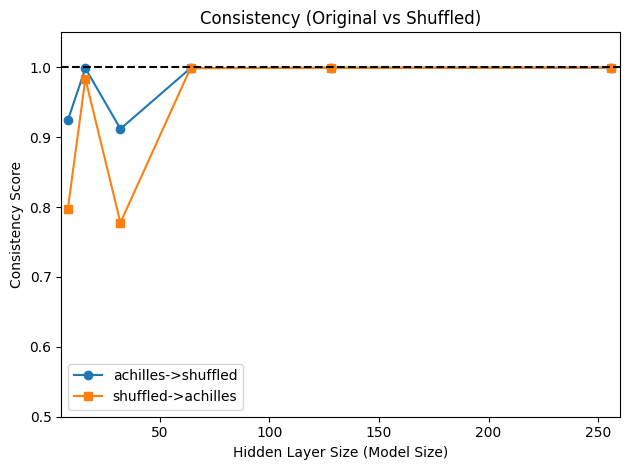

In [7]:
dimensionalities = [8, 16, 32, 64, 128, 256]
keys_to_use = ["achilles", "achilles_shuffled"]

posdir3_models, posdir3_embeddings = {}, {}
left, right = {}, {}

for mouse in keys_to_use:
    for dim in dimensionalities:
        model_path = f"./cebra_models/cebra_model_{mouse}_dim{dim}.pt"
        posdir3_models[(mouse, dim)] = cebra.CEBRA.load(model_path)
        posdir3_embeddings[(mouse, dim)] = posdir3_models[(mouse, dim)].transform(
            hippocampus_pos[mouse].neural_standardized
        )
        
        # left and right labels for the embedding
        right[(mouse, dim)] = hippocampus_pos[mouse].continuous_index[:,1] == 1
        left[(mouse, dim)] = hippocampus_pos[mouse].continuous_index[:,2] == 1

scores_original = {}
scores_shuffled = {}

for dim in dimensionalities:
    # We have 2 datasets for this dimension: [achilles, achilles_shuffled].
    embeddings = [posdir3_embeddings[(mouse, dim)] for mouse in keys_to_use]
    labels = [hippocampus_pos[mouse].continuous_index[:, 0] for mouse in keys_to_use]

    posdir_scores, _, _ = cebra.sklearn.metrics.consistency_score(
        embeddings=embeddings,
        labels=labels,
        dataset_ids=keys_to_use,  # ["achilles", "achilles_shuffled"]
        between="datasets"
    )
    scores_original[dim] = posdir_scores[0]
    scores_shuffled[dim] = posdir_scores[1]

plt.figure()

plt.plot(dimensionalities,
         [scores_original[d] for d in dimensionalities],
         marker='o', linestyle='-', label='achilles->shuffled')
plt.plot(dimensionalities,
         [scores_shuffled[d] for d in dimensionalities],
         marker='s', linestyle='-', label='shuffled->achilles')
plt.axhline(1.0, ls='--', c='k') 
# Set the x-axis limits and y-axis limits
plt.xlim(5, 260)
plt.ylim(0.5, 1.05)

plt.xlabel("Hidden Layer Size (Model Size)")
plt.ylabel("Consistency Score")
plt.title("Consistency (Original vs Shuffled)")
plt.legend()

plt.tight_layout()
plt.savefig("./cebra_figures/consistency_dim.png", bbox_inches="tight")
plt.show()


In [8]:
posdir3_models, posdir3_embeddings = {}, {}
left, right = {}, {}

for mouse in list(hippocampus_pos.keys()):
    # behavioral contrastive models
    posdir3_models[mouse] = cebra.CEBRA.load(f"./cebra_models/cebra_posdir3_model_{mouse}.pt")
    posdir3_embeddings[mouse] = posdir3_models[mouse].transform(hippocampus_pos[mouse].neural_standardized)
    
    # left and right labels for the embedding
    right[mouse] = hippocampus_pos[mouse].continuous_index[:,1] == 1
    left[mouse] = hippocampus_pos[mouse].continuous_index[:,2] == 1

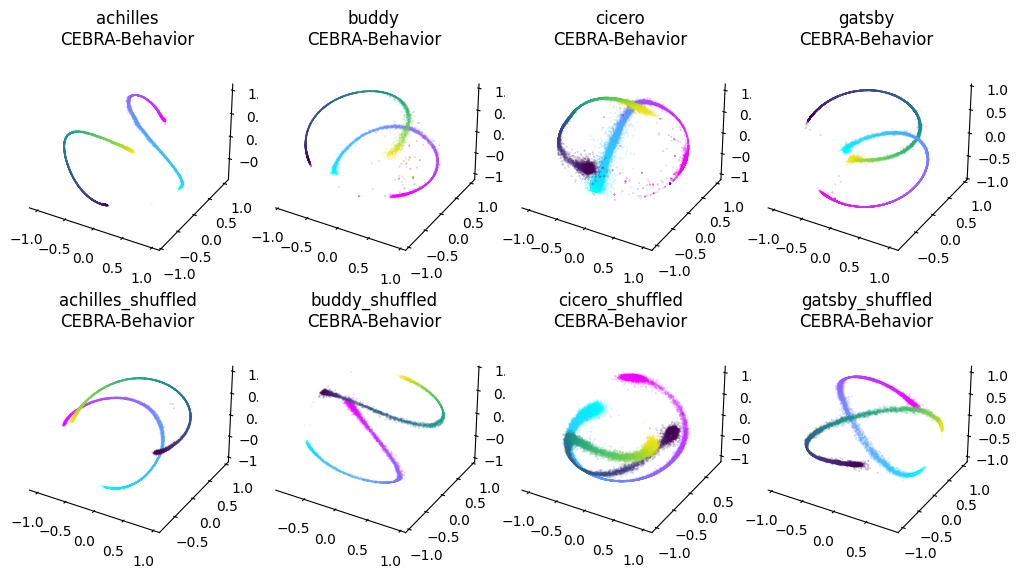

In [9]:
%matplotlib inline

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(241, projection='3d')
ax2 = plt.subplot(242, projection='3d')
ax3 = plt.subplot(243, projection='3d')
ax4 = plt.subplot(244, projection='3d')
ax5 = plt.subplot(245, projection='3d')
ax6 = plt.subplot(246, projection='3d')
ax7 = plt.subplot(247, projection='3d')
ax8 = plt.subplot(248, projection='3d')

axs_down = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for ax, mouse in  zip(axs_down, list(posdir3_embeddings.keys())): 
    for direction, cmap in zip([right[mouse], left[mouse]], ["cool", "viridis"]):
        ax = cebra.plot_embedding(
            ax=ax, 
            embedding=posdir3_embeddings[mouse][direction, :], 
            embedding_labels=hippocampus_pos[mouse].continuous_index[direction, 0], 
            title=f"{mouse}\nCEBRA-Behavior", 
            cmap=cmap
        )
plt.tight_layout()
plt.savefig("./cebra_figures/hippocampus_pos_embeddings.png", bbox_inches="tight")
plt.show()


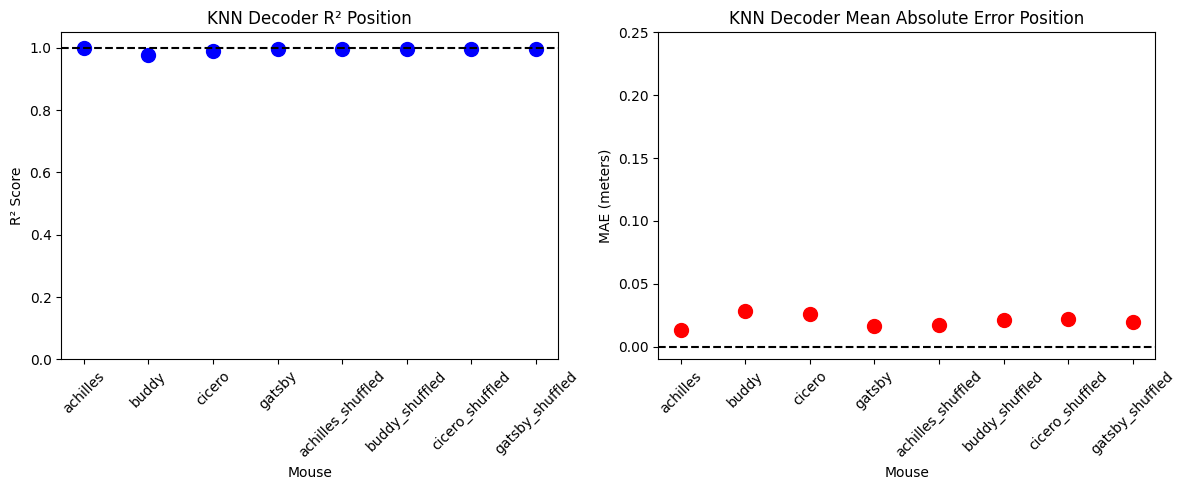

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

def decode_continuous_position(embedding, pos, test_frac=0.25, n_neighbors=40):
    """
    Decodes continuous position from a neural embedding using a KNN decoder.
    
    Parameters:
      embedding (np.array): Neural embedding of shape (time, embedding_dim).
      pos (np.array): Continuous position label (from hippocampus_pos.continuous_index[:, 0]).
      test_frac (float): Fraction of data (from the end) to use as test set.
      n_neighbors (int): Number of neighbors for the KNN regressor.
      
    Returns:
      dict: Contains:
         - 'knn_r2': R² score from the KNN decoder.
         - 'knn_mae': Mean absolute error of the KNN decoder on the test set.
    """
    # Determine the contiguous split index (since data is time series)
    T = embedding.shape[0]
    test_start = int(T * (1 - test_frac))
    
    # Split the data into training and testing sets
    X_train = embedding[:test_start]
    X_test  = embedding[test_start:]
    y_train = pos[:test_start]
    y_test  = pos[test_start:]
    
    # Train KNN regressor on training data
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric="cosine", algorithm="brute")
    knn.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred_knn = knn.predict(X_test)
    
    # Calculate metrics
    knn_r2 = r2_score(y_test, y_pred_knn)
    knn_mae = mean_absolute_error(y_test, y_pred_knn)
    
    return {
        'knn_r2': knn_r2,
        'knn_mae': knn_mae
    }

# Dictionary to store performance metrics for each mouse.
performance_results = {}

# Loop over each mouse in hippocampus_pos
for mouse in hippocampus_pos.keys():
    # Retrieve the embedding and corresponding continuous position (first column)
    embedding = posdir3_embeddings[mouse]
    pos = hippocampus_pos[mouse].continuous_index[:, 0]
    seed_everything(42)
    # Apply the decoding function and store the results
    performance_results[mouse] = decode_continuous_position(embedding, pos, test_frac=0.25, n_neighbors=5)

# Prepare data for plotting
mice = list(performance_results.keys())
knn_r2s = [performance_results[m]['knn_r2'] for m in mice]
knn_maes = [performance_results[m]['knn_mae'] for m in mice]

# Create two dot (scatter) plots with no grid and rotated x tick labels
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Dot plot for KNN R²
axs[0].scatter(mice, knn_r2s, color='blue', s=100)
axs[0].set_title("KNN Decoder R² Position")
axs[0].set_xlabel("Mouse")
axs[0].set_ylabel("R² Score")
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_ylim(0, 1.05)
axs[0].axhline(1.0, ls='--', c='k')

# Dot plot for KNN MAE
axs[1].scatter(mice, knn_maes, color='red', s=100)
axs[1].set_title("KNN Decoder Mean Absolute Error Position")
axs[1].set_xlabel("Mouse")
axs[1].set_ylabel("MAE (meters)")
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_ylim(-0.01, 0.25)
axs[1].axhline(0, ls='--', c='k')
plt.tight_layout()
plt.savefig("./cebra_figures/hippocampus_pos_decoding.png", bbox_inches="tight")
plt.show()


In [11]:
# labels to align the subjects is the position of the mouse in the arena
labels = [hippocampus_pos[mouse].continuous_index[:, 0]
          for mouse in list(hippocampus_pos.keys())]

# CEBRA-Behavior consistencies
posdir_scores, posdir_pairs, posdir_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(posdir3_embeddings.values()),
                                                                                       labels=labels,
                                                                                       dataset_ids=list(
                                                                                           posdir3_embeddings.keys()),
                                                                                       between="datasets")


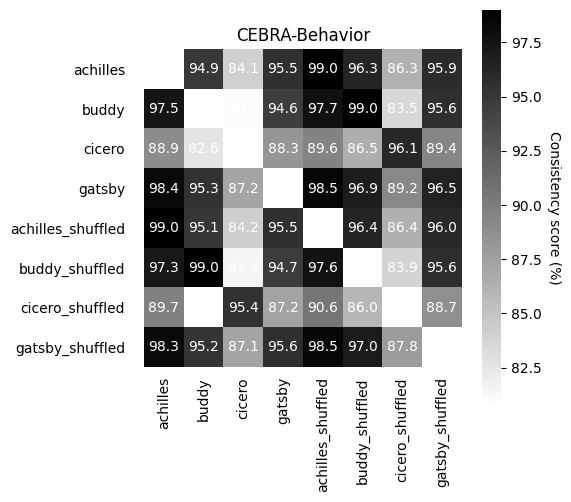

In [12]:
# Display consistency maps
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)

ax1 = cebra.plot_consistency(
    posdir_scores, pairs=posdir_pairs, datasets=posdir_subjects, ax=ax1, title="CEBRA-Behavior"
)

# Rotate the x-axis tick labels by 90 degrees
plt.setp(ax1.get_xticklabels(), rotation=90)
# Rotate the y-axis tick labels by 90 degrees
plt.setp(ax1.get_yticklabels(), rotation=0)
plt.setp(ax1.get_yticklabels(), ha='right')  # or 'center', 'left'

plt.tight_layout()
plt.savefig("./cebra_figures/consistency_all.png", bbox_inches="tight")
plt.show()
